# 1. Unit-ddpm arhitecture

In [6]:
#image
IMG_SIZE = 28
TRAIN_TWO_PATH = "drive/MyDrive/mnist/colorized-MNIST-master/training/2"
TRAIN_THREE_PATH = "drive/MyDrive/mnist/colorized-MNIST-master/training/3"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#diffusion
TIMESTEPS = 1000
RELEASE_TIME = 100

#hyperparams
DIM = 32
LR = 1e-5
BATCH_SIZE = 32

#training strategy
EPOCHS = 100
LOAD_FROM_CHECKPOINT = False
CHECKPOINT_DIR = "drive/MyDrive/generative_models/fundamental_basis/checkpoints"

### 1.1 Models

In [7]:
import torch
from torch import nn
import math


class Block_plain(nn.Module):
    def __init__(self, in_ch, out_ch, up=False):
        super().__init__()
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SimpleUnet_plain(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, in_dim=3, dim=64, out_dim=1):
        super().__init__()

        image_channels=in_dim

        down_channels = (1*dim, 2*dim, 4*dim, 8*dim, 16*dim)
        up_channels = (16*dim, 8*dim, 4*dim, 2*dim, 1*dim)
        out_dim = 1

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block_plain(down_channels[i], down_channels[i+1],) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block_plain(up_channels[i], up_channels[i+1], up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x):
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x)
        return torch.tanh(self.output(x))

In [8]:
!pip install einops

In [9]:
import torch
import functools
from torch import nn
from functools import partial
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch import einsum

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class LearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with learned sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.learned_sinusoidal_cond = learned_sinusoidal_cond

        if learned_sinusoidal_cond:
            sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond = None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

### 1.2 Diffusion

In [10]:
import torch
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Returns a linear schedule of betas from start to end with an input timestep
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device=device, noise=None):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    if noise is None:
      noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # formula ->
    # mean = square root of alpha prod
    # std = square root of 1 - alpha prod
    mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
    var = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    # mean + variance
    return  mean+var, noise.to(device)


# Define beta schedule
timesteps = TIMESTEPS
betas = linear_beta_schedule(timesteps=timesteps)

# Pre-calculate different terms for closed form
# alpha = 1-beta
alphas = 1. - betas
# alphas_cumprod = prod(alpha)
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

distance_fn = nn.MSELoss()
LAMBDA = 10

def train_one_epoch(ep, models, optimizers, data_loaderA, data_loaderB, identity = False, iterations=100):
  # gen1 = generator for domain 1
  # gen2 = generator for domain 2
  # cyc12 = transform domain 1 to domain 2
  # cyc21 = transform domain 2 to domain 1
  genA, genB, cycAB, cycBA = models
  genA.train()
  genB.train()
  cycAB.train()
  cycBA.train()

  #define optimizers
  optim_gen, optim_cyc = optimizers

  #tqdm loader
  pbar = tqdm(range(iterations), desc = f'Training Epoch {ep}')

  for i in pbar:

    #randonly sample images from 2 domain
    optim_gen.zero_grad()
    optim_cyc.zero_grad()
    xA0 = next(iter(data_loaderA))[0].unsqueeze(dim=0).to(device)
    xB0 = next(iter(data_loaderB))[0].unsqueeze(dim=0).to(device)

    # begin diffusion
    tA = torch.randint(0, timesteps, (xA0.shape[0],), device=device).long()
    tB = torch.randint(0, timesteps, (xB0.shape[0],), device=device).long()
    noiseA = torch.randn_like(xA0, device=device)
    noiseB = torch.randn_like(xB0, device=device)
    xB0_fake = cycAB(xA0)
    xA0_fake = cycBA(xB0)

    #add noise
    xAtA, _ = forward_diffusion_sample(xA0, tA, device, noiseA)
    xBtB, _ = forward_diffusion_sample(xB0, tB, device, noiseB)
    xAtB_fake, _ = forward_diffusion_sample(xA0_fake, tB, device, noiseA)
    xBtA_fake, _ = forward_diffusion_sample(xB0_fake, tA, device, noiseB)

    #update diffusion weight
    predA = genA(torch.cat([xAtA, xBtA_fake.detach()], dim=1), tA)
    predB = genB(torch.cat([xBtB, xAtB_fake.detach()], dim=1), tB)
    diffusion_loss = distance_fn(predA,noiseA) + distance_fn(predB,noiseB)
    diffusion_loss.backward()
    optim_gen.step()

    #update cycle weight
    predA = genA(torch.cat([xAtA, xBtA_fake], dim=1), tA)
    predA_fake = genA(torch.cat([xAtB_fake, xBtB], dim=1), tB)
    predB = genB(torch.cat([xBtB, xAtB_fake], dim=1), tB)
    predB_fake = genB(torch.cat([xBtA_fake, xAtA], dim=1), tA)
    cyc_loss = distance_fn(predA,noiseA) + distance_fn(predB,noiseB) + distance_fn(predA_fake,noiseA) + distance_fn(predB_fake,noiseB)

    if identity:
      xA0_cyc = cycBA(xB0_fake)
      xB0_cyc = cycAB(xA0_fake)
      cyc_loss += distance_fn(xA0_cyc, xA0)*LAMBDA + distance_fn(xB0_cyc, xB0)*LAMBDA
    cyc_loss.backward()
    optim_cyc.step()

    pbar.set_description(f"Epoch {ep} - Step {i+1}/{iterations} - Diff Loss = {round(diffusion_loss.item(),4)} - Cyc Loss = {round(cyc_loss.item(),4)}")

@torch.no_grad()
def translate_before_release(xA0, xBt, t, model):
  '''
  removes noise from a noisy image at timestep t before release time
  unless we're sampling the final image - some noise is sampled to increase variance
  '''
  noiseA = torch.randn_like(xA0)
  noiseB = torch.randn_like(xBt)
  if t.min() <= 0:
    noiseA = noiseA*0
    noiseB = noiseB*0
  xAt, _ = forward_diffusion_sample(xA0, t, device, noiseA)

  betas_t = get_index_from_list(betas, t, xBt.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, xBt.shape
  )
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, xBt.shape)
  predicted_noise = model(torch.cat([xBt, xAt], dim=1), t)
  model_mean = sqrt_recip_alphas_t * (xBt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
  posterior_variance_t = get_index_from_list(posterior_variance, t, xBt.shape)
  xBt_minus1 = model_mean + torch.sqrt(posterior_variance_t) * noiseB
  return xBt_minus1

@torch.no_grad()
def translate_after_release(xAt, xBt, t, model):
  '''
  removes noise from a noisy image at timestep t before release time
  unless we're sampling the final image - some noise is sampled to increase variance
  '''
  noiseA = torch.randn_like(xAt)
  noiseB = torch.randn_like(xBt)
  if t.min() <= 0:
    noiseA = noiseA*0
    noiseB = noiseB*0

  betas_t = get_index_from_list(betas, t, xBt.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, xBt.shape
  )
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, xBt.shape)
  predicted_noise = model(torch.cat([xBt, xAt], dim=1), t)
  model_mean = sqrt_recip_alphas_t * (xBt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
  posterior_variance_t = get_index_from_list(posterior_variance, t, xBt.shape)
  xBt_minus1 = model_mean + torch.sqrt(posterior_variance_t) * noiseB

  betas_t = get_index_from_list(betas, t, xAt.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, xAt.shape
  )
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, xAt.shape)
  predicted_noise = model(torch.cat([xAt, xBt], dim=1), t)
  model_mean = sqrt_recip_alphas_t * (xAt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
  posterior_variance_t = get_index_from_list(posterior_variance, t, xAt.shape)
  xAt_minus1 = model_mean + torch.sqrt(posterior_variance_t) * noiseA

  return xAt_minus1, xBt_minus1

@torch.no_grad()
def translate(xA0, model, release_time=1):
  model.eval()
  b = xA0.shape[0]
  xBt = torch.randn(xA0.shape).to(device)
  noiseA = torch.randn_like(xA0)
  t = torch.full((b,), max(release_time,0), device=device, dtype=torch.long)
  xAt, _ = forward_diffusion_sample(xA0, t, device, noiseA)
  for i in tqdm(range(timesteps)):
    time = timesteps-i-1
    t = torch.full((b,), time, device=device, dtype=torch.long)
    if time>release_time:
      xBt = translate_before_release(xA0, xBt, t, model)
    else:
      xAt, xBt = translate_after_release(xAt, xBt, t, model)
  return xBt

# 2. Loading dataset

In [11]:
import os
import numpy as np
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.data_dir = dir
        self.images = os.listdir(dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.images[index])
        image = np.array(Image.open(image_path))

        if self.transform:
          image = self.transform(image)

        return image



In [12]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/celeba/Dataset.zip -d  drive/MyDrive/celeba/

In [ ]:
!unzip drive/MyDrive/mnist/colorized_mnist.zip -d  drive/MyDrive/mnist

In [13]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize((128, 128))

                                ])

train_two_dataset = ImageDataset(TRAIN_TWO_PATH, transform=transforms)
train_three_dataset = ImageDataset(TRAIN_THREE_PATH, transform=transforms)

train_two_loader = DataLoader(train_two_dataset, batch_size=64, shuffle=True)
train_three_loader = DataLoader(train_three_dataset, batch_size=64, shuffle=True)

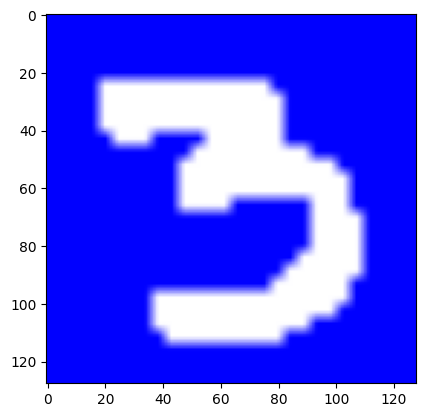

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(np.transpose(train_three_dataset[3], (1, 2, 0)))
plt.show()

# 3. Trainig

In [14]:
from torch.optim import Adam

def get_model(plain=False):
    if not plain:
        model = Unet(
            DIM,
            channels = 6,
            out_dim = 3,
            dim_mults = (1, 2, 4, 8, 8),
        )
    else:
        model = SimpleUnet_plain(
            in_dim=3,
            dim=DIM,
            out_dim=3,
        )
    print("Num params: ", sum(p.numel() for p in model.parameters()))

    return model


In [15]:
two_gen = get_model().to(device)
three_gen = get_model().to(device)
two2three = get_model(plain=True).to(device)
three2two = get_model(plain=True).to(device)

#optimizers
optim_gen = Adam(list(two_gen.parameters())+list(three_gen.parameters()), lr=LR)
optim_cyc = Adam(list(two2three.parameters())+list(three2two.parameters()), LR)

LOAD_FROM_CHECKPOINT = True

if LOAD_FROM_CHECKPOINT:

  two_gen.load_state_dict(torch.load(CHECKPOINT_DIR + '/two_gen.pt'))
  three_gen.load_state_dict(torch.load(CHECKPOINT_DIR + '/three_gen.pt'))
  two2three.load_state_dict(torch.load(CHECKPOINT_DIR + '/two2three.pt'))
  three2two.load_state_dict(torch.load(CHECKPOINT_DIR + '/three2two.pt'))



models = [
    two_gen,
    three_gen,
    two2three,
    three2two
]

for model in models:
  model.train()

optimizers = [
    optim_gen,
    optim_cyc
]

EPOCHS = 100

for ep in range(1, EPOCHS):
  train_one_epoch(ep, models, optimizers, train_two_loader, train_three_loader, identity = True)

  torch.save(two_gen.state_dict(), CHECKPOINT_DIR + '/two_gen.pt')
  torch.save(three_gen.state_dict(), CHECKPOINT_DIR + '/three_gen.pt')
  torch.save(two2three.state_dict(), CHECKPOINT_DIR + '/two2three.pt')
  torch.save(three2two.state_dict(), CHECKPOINT_DIR + '/three2two.pt')


Num params:  17438883
Num params:  17438883
Num params:  15591235
Num params:  15591235


# 3. Sampling

In [16]:
TEST_TWO_PATH = "drive/MyDrive/mnist/colorized-MNIST-master/testing/2"
TEST_THREE_PATH = "drive/MyDrive/mnist/colorized-MNIST-master/testing/3"


test_two_dataset = ImageDataset(TEST_TWO_PATH, transform=transforms)
test_three_dataset = ImageDataset(TEST_THREE_PATH, transform=transforms)

test_two_loader = DataLoader(test_two_dataset, batch_size=64, shuffle=True)
test_three_loader = DataLoader(test_three_dataset, batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1000/1000 [00:43<00:00, 23.02it/s]


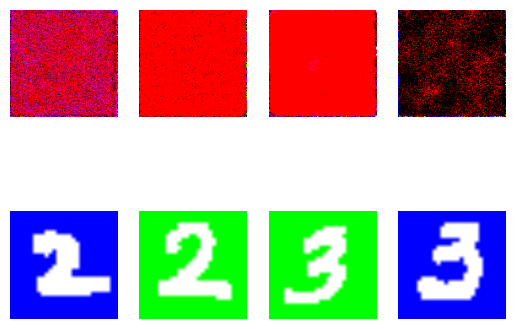

In [17]:
import matplotlib.pyplot as plt


for index in range(2):

    next_two = next(iter(test_two_loader))[4].unsqueeze(dim=0).to(device)
    next_three = next(iter(test_three_loader))[4].unsqueeze(dim=0).to(device)

    two_gen.eval()
    three_gen.eval()

    with torch.no_grad():
      pred_three = translate(next_two, three_gen, RELEASE_TIME)
      pred_two = translate(next_three, two_gen, RELEASE_TIME)

    plt.subplot(2, 4, index + 1)
    plt.imshow(np.transpose(pred_two[0].cpu(), (1, 2, 0)))
    plt.axis('off')

    plt.subplot(2, 4, index + 5)
    plt.imshow(np.transpose(next_two[0].cpu(), (1, 2, 0)))
    plt.axis('off')

    plt.subplot(2, 4, index + 3)
    plt.imshow(np.transpose(pred_three[0].cpu(), (1, 2, 0)))
    plt.axis('off')

    plt.subplot(2, 4, index + 7)
    plt.imshow(np.transpose(next_three[0].cpu(), (1, 2, 0)))
    plt.axis('off')


plt.show()
